# Segmentación mediante grafos


Este algoritmo construye primero un grafo de adyacencia de regiones y luego realiza el corte mínimo normalizado. En fuentes puedes conocer más sobre cómo funciona el agoritmo. 

Vamos a ver un ejemplo:

In [1]:
!pip install --upgrade scikit-image

     |████████████████████████████████| 12.4MB 5.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


## Corte normalizado

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  del sys.path[0]


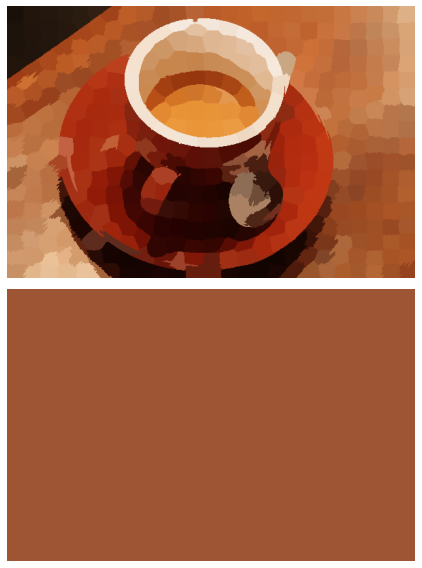

In [2]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


img = data.coffee()

labels1 = segmentation.slic(img, compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

## GrabCut

En este ejemplo vamos a ver cómo podemos usar el corte mínimo de un grafo para segmentar background de foreground en una imagen.

Pongamos como ejemplo esta imagen:

<img src="https://opencv-python-tutroals.readthedocs.io/en/latest/_images/grabcut_output1.jpg">

Como puedes ver, disponemos de una bounding box y de semillas para background y para foreground.

Lo que hace el algoritmo de GrabCut es construir un grafo asignando todos los pixels o bien a una fuente a un sumidero, y después encuentra el mínimo corte en dicho grafo:

<img src="https://opencv-python-tutroals.readthedocs.io/en/latest/_images/grabcut.jpg">

Tenemos la suerte de que este algoritmo se encuentra implementado en OpenCV: `cv2.grabCut()`. Veamos sus argumentos.

`img` - Input image

`mask` - It is a mask image where we specify which areas are background, foreground or probable background/foreground etc. It is done by the following flags, cv2.GC_BGD, cv2.GC_FGD, cv2.GC_PR_BGD, cv2.GC_PR_FGD, or simply pass 0,1,2,3 to image.

`rect` - It is the coordinates of a rectangle which includes the foreground object in the format (x,y,w,h)

`bdgModel, fgdModel` - These are arrays used by the algorithm internally. You just create two np.float64 type zero arrays of size (1,65).

`iterCount` - Number of iterations the algorithm should run.

`mode` - It should be cv2.GC_INIT_WITH_RECT or cv2.GC_INIT_WITH_MASK or combined which decides whether we are drawing rectangle or final touchup strokes.

First let’s see with rectangular mode. We load the image, create a similar mask image. We create fgdModel and bgdModel. We give the rectangle parameters. It’s all straight-forward. Let the algorithm run for 5 iterations. Mode should be cv2.GC_INIT_WITH_RECT since we are using rectangle. Then run the grabcut. It modifies the mask image. In the new mask image, pixels will be marked with four flags denoting background/foreground as specified above. So we modify the mask such that all 0-pixels and 2-pixels are put to 0 (ie background) and all 1-pixels and 3-pixels are put to 1(ie foreground pixels). Now our final mask is ready. Just multiply it with input image to get the segmented image.

In [3]:
!wget https://raw.githubusercontent.com/abidrahmank/OpenCV2-Python-Tutorials/master/data/messi5.jpg

--2021-02-17 08:48:27--  https://raw.githubusercontent.com/abidrahmank/OpenCV2-Python-Tutorials/master/data/messi5.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72937 (71K) [image/jpeg]
Saving to: ‘messi5.jpg’


messi5.jpg            0%[                    ]       0  --.-KB/s               
messi5.jpg          100%[===================>]  71.23K  --.-KB/s    in 0.01s   

2021-02-17 08:48:27 (4.94 MB/s) - ‘messi5.jpg’ saved [72937/72937]



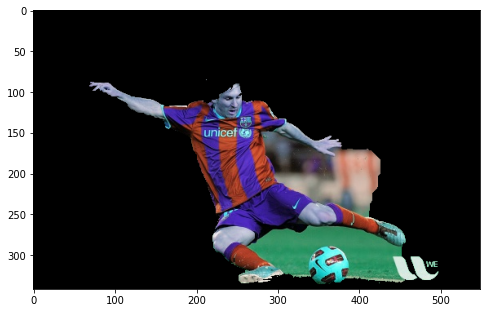

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

img_orig = cv2.imread('messi5.jpg')
mask = np.zeros(img_orig.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (50,50,450,290)
cv2.grabCut(img_orig, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img_orig*mask2[:,:,np.newaxis]

plt.imshow(img)

Fíjate que el pelo y el cesped entre las piernas no se ha segmentado bien. ¿Cómo podemos arreglarlo?

In [5]:
!wget -O newmask.png https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ6doDpZUR3q0TeUQyjBUc_dB-N6xBfCnNOp4SbxDumtKDB_1TG&s

/bin/bash: s: command not found
--2021-02-17 08:48:31--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ6doDpZUR3q0TeUQyjBUc_dB-N6xBfCnNOp4SbxDumtKDB_1TG
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 173.194.210.102, 173.194.210.139, 173.194.210.113, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|173.194.210.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2798 (2.7K) [image/png]
Saving to: ‘newmask.png’


newmask.png           0%[                    ]       0  --.-KB/s               
newmask.png         100%[===================>]   2.73K  --.-KB/s    in 0s      

2021-02-17 08:48:31 (27.3 MB/s) - ‘newmask.png’ saved [2798/2798]



(<matplotlib.image.AxesImage at 0x7fdcdf149c18>,
 <matplotlib.image.AxesImage at 0x7fdcdf149ef0>)

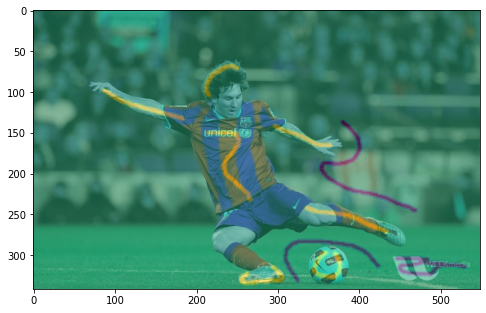

In [6]:
# newmask is the mask image I manually labelled
newmask = cv2.imread('newmask.png',0)
newmask = cv2.resize(newmask, img.shape[:2][::-1])
plt.imshow(img_orig), plt.imshow(newmask, alpha=0.5)

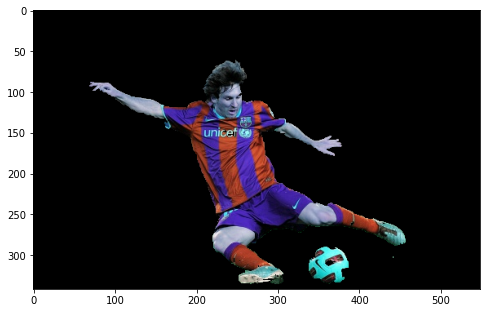

In [7]:
# whereever it is marked white (sure foreground), change mask=1
# whereever it is marked black (sure background), change mask=0
mask[newmask == 0] = 0
mask[newmask == 255] = 1

mask, bgdModel, fgdModel = cv2.grabCut(img_orig,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)

mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img_orig*mask[:,:,np.newaxis]
plt.imshow(img)

Y afinando más la máscara, podríamos llegar a obtener perfectamente a Messi sin nada de fondo.

### Fuentes:

- https://scikit-image.org/docs/0.16.x/auto_examples/segmentation/plot_ncut.html?highlight=normalized%20cut
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_grabcut/py_grabcut.html

### Recursos interesantes:

- https://medium.com/stellargraph/knowing-your-neighbours-machine-learning-on-graphs-9b7c3d0d5896